In [7]:
import numpy as np
import pandas as pd
import pyddm
import os
import utils
import models
from scipy import interpolate
import matplotlib.pyplot as plt

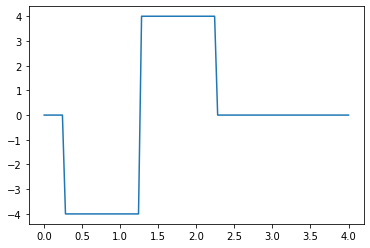

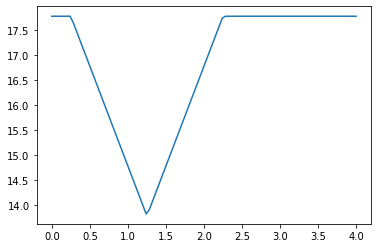

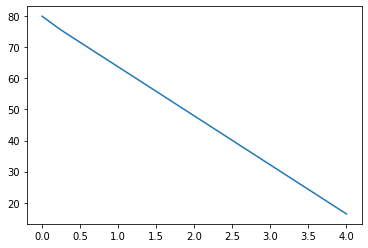

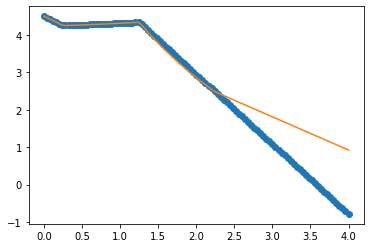

In [49]:
# this function will be a part of 02_fit_model.py
t = np.linspace(0, 4, 101)

acceleration_timings = np.array([0., 0.25, 1.25, 2.25])

d_0 = 80
tta_0 = 4.5
v_0 = d_0/tta_0
a_condition = np.array([0., -4., 4., 0.])
v_condition = np.concatenate([[v_0], v_0+np.cumsum(np.diff(acceleration_timings)*a_condition[:-1])])
d_condition = np.concatenate([[d_0], d_0-np.cumsum(np.diff(acceleration_timings)*(v_condition[1:]+v_condition[:-1])/2)])
tta_condition = d_condition/v_condition

# acceleration is piecewise-constant
f_a = interpolate.interp1d(acceleration_timings, a_condition, kind=0, fill_value="extrapolate", bounds_error=False)
# under piecewise-constant acceleration, v is piecewise-linear
f_v = interpolate.interp1d(acceleration_timings, v_condition, kind=1, fill_value=(v_0, v_0), bounds_error=False)
f_tta = interpolate.interp1d(acceleration_timings, tta_condition, kind=1, fill_value="extrapolate")
# under piecewise-linear v, d is piecewise-quadratic, but piecewise-linear approximation is very close
f_d = interpolate.interp1d(acceleration_timings, d_condition, kind=1, fill_value="extrapolate")

a_t = f_a(t)
v_t = f_v(t)
d_t = f_d(t)
tta_t = f_tta(t)

plt.plot(t, a_t)
plt.figure()
plt.plot(t, v_t)
plt.figure()
plt.plot(t, d_t)
plt.figure()
plt.plot(t, tta_t, marker="o")
plt.plot(t, d_t/v_t)
# assume acceleration is piecewise-linear? more general case would require integrating -> expensive?


def get_env_state(t, tta_condition, d_condition, a_condition):
    # This one will be called a lot, so ideally we'd want to precalculate everything at initialization and then just look up the value at time t
    # start with the most straightforward approach, then optimize if it's slow or gives different results
    # that is, don't pre-calculate anything, just do vector-based integration of a to get velocities and
    # return tta, d, a
    pass

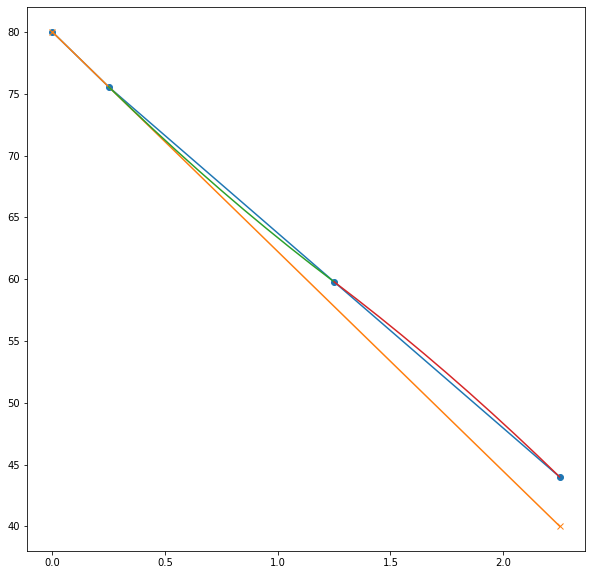

In [46]:
plt.figure(figsize=(10,10))
plt.plot(acceleration_timings, d_condition, marker="o")
plt.plot([0, 2.25], [80, 80-2.25*17.77], marker="x")
t_1 = np.linspace(0.25, 1.25, 11)
d_1 = d_condition[1] - v_condition[1]*(t_1-t_1[0]) - a_condition[1]*(t_1-t_1[0])**2/2
t_2 = np.linspace(1.25, 2.25, 11)
d_2 = d_condition[2] - v_condition[2]*(t_2-t_2[0]) - a_condition[2]*(t_2-t_2[0])**2/2
plt.plot(t_1, d_1)
plt.plot(t_2, d_2)

In [2]:
def get_model_measures(model, condition):
    sol = model.solve(condition)
    mean_rt_error = np.sum(sol.pdf_err()*model.t_domain())*model.dt / sol.prob_error()
    return condition["tta"], condition["d"], condition["a"], \
           sol.prob_correct(), sol.mean_decision_time(), mean_rt_error

def get_model_rt_distr(model, condition, kind="cdf"):
    sol = model.solve(condition)
    return pd.DataFrame({"tta_condition": condition["tta"],
                         "d_condition":  condition["d"],
                         "a_condition": condition["a"],
                         "t": model.t_domain(),
                         "rt_corr_distr": (sol.cdf_corr() if kind=="cdf" else sol.pdf_corr())/sol.prob_correct(),
                         "rt_error_distr": (sol.cdf_err() if kind=="cdf" else sol.pdf_err())/sol.prob_error()})

def initialize_model(model_no, param_set):
    simulation_params = {"dt": 0.01, "duration": 5.0}

    if model_no == 1:
        # drift only depends on TTA and distance (2020 version)
        overlay = models.OverlayNonDecisionGaussian(ndt_location=param_set.ndt_location, ndt_scale=param_set.ndt_scale)
        bound = models.BoundCollapsingTta(b_0=param_set.b_0, k=param_set.k, r=param_set.r, tta_crit=param_set.tta_crit)
        drift = models.DriftTtaDistance(alpha=param_set.alpha, beta_d=param_set.beta_d,
                                               beta_tta_or=param_set.beta_tta_or, theta=param_set.theta)

        model = pyddm.Model(name="Model %i" % model_no, drift=drift, bound=bound, overlay=overlay,
                      noise=pyddm.NoiseConstant(noise=1), T_dur=models.ModelDynamicDriftCollapsingBounds.T_dur)
    # elif model_no == 2:
    #     # re-implementation of Model 1 with the same acceleration pattern for all conditions (a=0)
    #     # results should be the same as Model 1, just for sanity check purposes
    #     gaze_sample_f = interpolate.interp1d(t, gaze_sample)
    #
    #     overlay = models.OverlayNonDecisionGaussian(ndt_location=param_set.ndt_location, ndt_scale=param_set.ndt_scale)
    #     bound = models.BoundCollapsingTta(b_0=param_set.b_0, k=param_set.k, r=param_set.r, tta_crit=param_set.tta_crit)
    #     drift = models.DriftGaze(alpha=param_set.alpha, beta_d=param_set.beta_d, beta_tta_or=param_set.beta_tta_or,
    #                              theta=param_set.theta, gamma=param_set.gamma, gaze_sample_f=gaze_sample_f)
    #
    #     model = pyddm.Model(name="Model %i" % model_no, drift=drift, bound=bound, overlay=overlay,
    #                   noise=pyddm.NoiseConstant(noise=1), T_dur=simulation_params["duration"])
    # elif model_no == 3:
    #     # model with gaze-dependent access to perceptual information
    #     gaze_sample = helper.get_mean_gaze_rate(simulation_params)
    #     t = np.linspace(0, simulation_params["duration"], len(gaze_sample))
    #     gaze_sample_f = interpolate.interp1d(t, gaze_sample)
    #
    #     overlay = models.OverlayNonDecisionGaussian(ndt_location=param_set.ndt_location, ndt_scale=param_set.ndt_scale)
    #     bound = models.BoundCollapsingGeneralizedGap(b_0=param_set.b_0, k=param_set.k, beta_d=param_set.beta_d,
    #                                                  beta_tta_or=param_set.beta_tta_or, theta=param_set.theta,
    #                                                  gamma=param_set.gamma, gaze_sample_f=gaze_sample_f)
    #     drift = models.DriftGaze(alpha=param_set.alpha, beta_d=param_set.beta_d, beta_tta_or=param_set.beta_tta_or,
    #                              theta=param_set.theta, gamma=param_set.gamma, gaze_sample_f=gaze_sample_f)
    #
    #     model = pyddm.Model(name="Model %i" % model_no, drift=drift, bound=bound, overlay=overlay,
    #                   noise=pyddm.NoiseConstant(noise=1), T_dur=simulation_params["duration"])

    else:
        model = None

    return model

def simulate_model(model_no, param_set, conditions, ret="measures"):
    """
    Set ret to "measures" or "rt_cdf" or "rt_pdf" for saving p_turn and mean RT or RT CDF or RT PDF
    """
    model = initialize_model(model_no, param_set)

    if ret=="measures":
        sim_result = pd.DataFrame([get_model_measures(model, condition) for condition in conditions],
                                  columns=["tta_condition", "d_condition", "is_gap_accepted", "RT_merge", "RT_wait"])
    else:
        sim_result = pd.concat([get_model_rt_distr(model, condition, kind=ret[-3:]) for condition in conditions])
    sim_result["subj_id"] = param_set.subj_id
    return sim_result

In [3]:
def save_sim_results(model_no, file_name, conditions=None, cross_validation=False, ret="measures"):
    if model_no == 1:
        model_name = "drift_tta_distance"
    # elif model_no == 2:
    #     model_name = "gaze_dependent_model"
    # elif model_no == 3:
    #     model_name = "gaze_dependent_bound_generalized_gap_model"
    else:
        raise ValueError("Wrong model_no")

    path = os.path.join("fit_results", model_name)
    parameters = pd.read_csv(os.path.join(path, file_name))

    sim_results = [simulate_model(model_no, param_set,
                                  [param_set[["tta_condition", "d_condition", "tta_or_condition"]].to_dict()] if cross_validation
                                  else conditions,
                                  ret=ret)
                   for idx, param_set in parameters.iterrows()]

    sim_results = pd.concat(sim_results)
    sim_results.to_csv(os.path.join(path, "simulation_results", file_name.replace("parameters_fitted", ret)), index=False)

In [5]:
conditions = [{"tta": tta, "d": d, "a": [0, 0, 0, 0]}
              for tta in np.linspace(3, 7, 9)
              for d in np.linspace(10, 50, 5)]

# up-to-date

In [15]:
save_sim_results(model_no=1, file_name="subj_all_parameters_fitted.csv", conditions=conditions, cross_validation=False,
                 ret="measures")

In [14]:
save_sim_results(model_no=2, file_name="subj_all_parameters_fitted.csv", conditions=conditions, cross_validation=False,
                 ret="measures")

In [7]:
save_sim_results(model_no=3, file_name="subj_all_parameters_fitted.csv", conditions=conditions, cross_validation=False,
                 ret="measures")